In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from numpy import radians, sin, cos, arcsin, sqrt
def dist(a, b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    x1, y1, x2, y2 = map(radians, [a[0], a[1], b[0], b[1]])
    dx = x2 - x1
    dy = y2 - y1
    a = sin(dy/2)**2 + cos(y1) * cos(y2) * sin(dx/2)**2
    c = 2 * arcsin(sqrt(a))
    # Earth`s radius in kilometers
    km = 6372.795 * c
    return km

In [4]:
plt.style.use('classic')   # try another styles: 'classic'

srcData = "G:/1_Data1/sea/AllSea.txt"
destData = "G:/1_Data1/sea/AllSeaGisOut.txt"
obrisData = "G:/1_Data1/obris/obris.dat"
# srcData = "~/methaneSea.dat

In [5]:
df = pd.read_csv(srcData,
                 header=0,
                 # skip_blank_lines=True,
                 skipinitialspace=True,
                 na_values='--',
                 skiprows=[1,2,3,4],
                 sep='\t',
                 decimal=',',
                 # nrows=100000,
                 )
df

,DateTime,Longitude,Latitude,Tair,Pair,Twater,pCO2Air,pCH4Air,pCO2Wtr,pCH4Wtr,dpCO2,dpCH4,cCO2Wtr,cCH4Wtr
0,28.05.2013 22:00:38,104.649879,51.781395,NaN,NaN,3.00,402.425575,NaN,464.0,NaN,NaN,NaN,NaN,NaN
1,28.05.2013 22:01:38,104.649879,51.781395,NaN,NaN,3.00,402.425706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28.05.2013 22:02:38,104.649879,51.781395,NaN,NaN,3.00,402.425837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28.05.2013 22:03:38,104.649879,51.781395,NaN,NaN,3.00,402.425968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28.05.2013 22:04:38,104.649879,51.781395,NaN,NaN,3.00,402.426099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316388,14.06.2022 03:41:02,105.515258,51.876617,10.89,95629.9,3.94,405.528040,1.980042,NaN,NaN,NaN,NaN,NaN,NaN
316389,14.06.2022 03:41:12,105.514649,51.876568,10.92,95630.6,3.94,405.531008,1.980056,NaN,NaN,NaN,NaN,NaN,NaN
316390,14.06.2022 03:41:22,105.514061,51.876512,10.96,95628.8,3.94,405.523375,1.980019,NaN,NaN,NaN,NaN,NaN,NaN
316391,14.06.2022 03:41:32,105.513452,51.876462,10.97,95628.0,3.94,405.519983,1.980002,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
obris = pd.read_csv(obrisData,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                    )

In [8]:
longStep = 0.01
latStep = 0.005

df['long'] = (df['Longitude']/longStep).round()*longStep
df['lat'] = (df['Latitude']/latStep).round()*latStep

cols_to_calc = {'pCO2Wtr': ['mean', 'std', 'count'],
                'pCH4Wtr': ['mean', 'std', 'count'],
                'cCO2Wtr': ['mean', 'std', 'count'],
                'cCH4Wtr': ['mean', 'std', 'count'],
                'dpCO2': ['mean', 'std', 'count'],
                'dpCH4': ['mean', 'std', 'count'],
                'pCO2Air': ['mean', 'std', 'count'],
                'pCH4Air': ['mean', 'std', 'count'],}
res = df.groupby(['long', 'lat'], as_index=False).agg(cols_to_calc)
res

long     lat      pCO2Wtr                       pCH4Wtr              \
                              mean         std count        mean         std   
0      103.75  51.695   275.989480    5.873521    97    3.249971    0.167134   
1      103.76  51.690   272.876610    7.553146    78    3.317833    0.187441   
2      103.76  51.695   277.061851    6.816228     7    3.021134    0.173398   
3      103.77  51.690   265.298654    0.659972     3    3.231728    0.036763   
4      103.77  51.695   298.704548    4.469396     2    2.828689    0.003321   
...       ...     ...          ...         ...   ...         ...         ...   
16155  109.86  55.695   381.324087    0.529799    22   15.172322    0.644640   
16156  109.86  55.700   630.294015  290.153391   170  334.358061  173.110325   
16157  109.86  55.705  1239.613765   91.560227   163  136.237813  101.601672   
16158  109.87  55.695          NaN         NaN     0         NaN         NaN   
16159  109.87  55.700          NaN         NaN     0         NaN         NaN   

              cCO2Wtr            ... dpCO2       dpCH4                    \
      count      mean       std  ... count        mean         std count   
0        97  0.798586  0.020140  ...    97    1.377225    0.166962    97   
1        78  0.790670  0.022857  ...    78    1.444355    0.187415    78   
2         7  0.823857  0.021285  ...     7    1.149656    0.173386     7   
3         3  0.762204  0.001896  ...     3    1.357611    0.036753     3   
4         2  0.889964  0.013822  ...     2    0.957345    0.003327     2   
...     ...       ...       ...  ...   ...         ...         ...   ...   
16155    22  1.173230  0.001630  ...    22   13.327322    0.644640    22   
16156    84  1.501778  0.629002  ...   170  332.440153  173.100386    84   
16157   155  2.932251  0.208960  ...   163  133.947328  101.611285   155   
16158     0       NaN       NaN  ...     0         NaN         NaN     0   
16159     0       NaN       NaN  ...     0         NaN         NaN     0   

          pCO2Air                   pCH4Air                  
             mean       std count      mean       std count  
0      389.591867  2.379859    33  1.834692  0.006959    33  
1      387.869996  1.498975    27  1.836166  0.007219    27  
2             NaN       NaN     0       NaN       NaN     0  
3      388.121710  0.697970     3  1.841502  0.007639     3  
4      387.933973  0.108019     3  1.833689  0.006223     3  
...           ...       ...   ...       ...       ...   ...  
16155         NaN       NaN     0       NaN       NaN     0  
16156  401.967634  7.799480   250  1.941150  0.079300   250  
16157  428.995328  8.050149   323  2.283908  0.145448   323  
16158         NaN       NaN     0       NaN       NaN     0  
16159         NaN       NaN     0       NaN       NaN     0  

[16160 rows x 26 columns]

In [ ]:
res['toobris'] = 0

for i in range(len(res)):
    min_dist = 100
    for j in range(len(obris)):
        dista = dist((res['long'][i], res['lat'][i]), (obris['long'][j], obris['lat'][j]))
        if (min_dist > dista):
            min_dist = dista
    res.at[i, 'toobris'] = min_dist

In [10]:
res.to_csv(destData,
           sep='\t',
           )

                   DateTime   Longitude   Latitude   Tair     Pair  Twater  \
0       28.05.2013 22:00:38  104.649879  51.781395    NaN      NaN    3.00   
1       28.05.2013 22:01:38  104.649879  51.781395    NaN      NaN    3.00   
2       28.05.2013 22:02:38  104.649879  51.781395    NaN      NaN    3.00   
3       28.05.2013 22:03:38  104.649879  51.781395    NaN      NaN    3.00   
4       28.05.2013 22:04:38  104.649879  51.781395    NaN      NaN    3.00   
...                     ...         ...        ...    ...      ...     ...   
316388  14.06.2022 03:41:02  105.515258  51.876617  10.89  95629.9    3.94   
316389  14.06.2022 03:41:12  105.514649  51.876568  10.92  95630.6    3.94   
316390  14.06.2022 03:41:22  105.514061  51.876512  10.96  95628.8    3.94   
316391  14.06.2022 03:41:32  105.513452  51.876462  10.97  95628.0    3.94   
316392  14.06.2022 03:41:42  105.512819  51.876409  10.97  95628.3    3.94   

           pCO2Air   pCH4Air  pCO2Wtr  pCH4Wtr  dpCO2  dpCH4  c

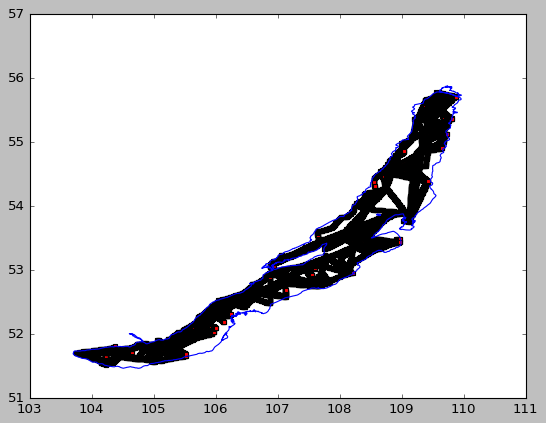

In [11]:
%matplotlib inline
valMax = res['pCH4Wtr'].max

fig = plt.figure()

# wether this or those
plt.scatter(res['long'], res['lat'], c='r', s=10, marker='s')
plt.plot(obris['long'], obris['lat'], 'b-')

fig.savefig('gis.png')

print(df)
print(res)